In [1]:
# Model Configuration
UNITS = 2 ** 11 # 2048
ACTIVATION = 'relu'
DROPOUT = 0.1

# Training Configuration
BATCH_SIZE_PER_REPLICA = 2 ** 11 # powers of 128 are best

The next few sections set up the TPU computation, data pipeline, and neural network model. If you'd just like to see the results, feel free to skip to the end!

# Setup #

In addition to our imports, this section contains some code that will connect our notebook to the TPU and create a **distribution strategy**. Each TPU has eight computational cores acting independently. With a distribution strategy, we define how we want to divide up the work between them.

In [2]:
# TensorFlow
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

# Detect and init the TPU
try: # detect TPUs
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect() # TPU detection
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError: # detect GPUs
    strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
print("Number of accelerators: ", strategy.num_replicas_in_sync)
    
# Plotting
import pandas as pd
import matplotlib.pyplot as plt

# Matplotlib defaults
plt.style.use('seaborn-whitegrid')
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)


# Data
AUTO = tf.data.experimental.AUTOTUNE


# Model
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks

2022-07-14 13:48:52.652407: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-07-14 13:48:52.652517: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Tensorflow version 2.4.1


2022-07-14 13:48:58.208973: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-07-14 13:48:58.211736: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-07-14 13:48:58.211777: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-14 13:48:58.211804: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (0baf3be9d8af): /proc/driver/nvidia/version does not exist
2022-07-14 13:48:58.214623: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

Number of accelerators:  8


Notice that TensorFlow now detects eight accelerators. Using a TPU is a bit like using eight GPUs at once.

# Load Data #

The dataset has been encoded in a binary file format called *TFRecords*. These two functions will parse the TFRecords and build a TensorFlow `tf.data.Dataset` object that we can use for training.

In [3]:
def make_decoder(feature_description):
    def decoder(example):
        example = tf.io.parse_single_example(example, feature_description)
        features = tf.io.parse_tensor(example['features'], tf.float32)
        features = tf.reshape(features, [28])
        label = example['label']
        return features, label
    return decoder

def load_dataset(filenames, decoder, ordered=False):
    AUTO = tf.data.experimental.AUTOTUNE
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False
    dataset = (
        tf.data
        .TFRecordDataset(filenames, num_parallel_reads=AUTO)
        .with_options(ignore_order)
        .map(decoder, AUTO)
    )
    return dataset

In [4]:
dataset_size = int(11e6)
validation_size = int(5e5)
training_size = dataset_size - validation_size

# For model.fit
batch_size = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync
steps_per_epoch = training_size // batch_size
validation_steps = validation_size // batch_size

# For model.compile
steps_per_execution = 256

In [5]:
feature_description = {
    'features': tf.io.FixedLenFeature([], tf.string),
    'label': tf.io.FixedLenFeature([], tf.float32),
}
decoder = make_decoder(feature_description)

data_dir = '../input/higgs-boson'
train_files = tf.io.gfile.glob(data_dir + '/training' + '/*.tfrecord')
valid_files = tf.io.gfile.glob(data_dir + '/validation' + '/*.tfrecord')

ds_train = load_dataset(train_files, decoder, ordered=False)
ds_train = (
    ds_train
    .cache()
    .repeat()
    .shuffle(2 ** 19)
    .batch(batch_size)
    .prefetch(AUTO)
)

ds_valid = load_dataset(valid_files, decoder, ordered=False)
ds_valid = (
    ds_valid
    .batch(batch_size)
    .cache()
    .prefetch(AUTO)
)

2022-07-14 13:49:05.091999: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2022-07-14 13:49:05.185940: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.


# Model #

Now that the data is ready, let's define the network. We're defining the deep branch of the network using Keras's *Functional API*, which is a bit more flexible that the `Sequential` method we used in the course.


In [6]:
def dense_block(units, activation, dropout_rate, l1=None, l2=None):
    def make(inputs):
        x = layers.Dense(units)(inputs)
        x = layers.BatchNormalization()(x)
        x = layers.Activation(activation)(x)
        x = layers.Dropout(dropout_rate)(x)
        return x
    return make

with strategy.scope():
    # Wide Network
    wide = keras.experimental.LinearModel()

    # Deep Network
    inputs = keras.Input(shape=[28])
    x = dense_block(UNITS, ACTIVATION, DROPOUT)(inputs)
    x = dense_block(UNITS, ACTIVATION, DROPOUT)(x)
    x = dense_block(UNITS, ACTIVATION, DROPOUT)(x)
    x = dense_block(UNITS, ACTIVATION, DROPOUT)(x)
    x = dense_block(UNITS, ACTIVATION, DROPOUT)(x)
    outputs = layers.Dense(1)(x)
    deep = keras.Model(inputs=inputs, outputs=outputs)
    
    # Wide and Deep Network
    wide_and_deep = keras.experimental.WideDeepModel(
        linear_model=wide,
        dnn_model=deep,
        activation='sigmoid',
    )

wide_and_deep.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['AUC', 'binary_accuracy'],
    experimental_steps_per_execution=steps_per_execution,
)

# Training #

During training, we'll use the `EarlyStopping` callback as usual. Notice that we've also defined a **learning rate schedule**. It's been found that gradually decreasing the learning rate over the course of training can improve performance (the weights "settle in" to a minimum). This schedule will multiply the learning rate by `0.2` if the validation loss didn't decrease after an epoch.

In [7]:
early_stopping = callbacks.EarlyStopping(
    patience=2,
    min_delta=0.001,
    restore_best_weights=True,
)

lr_schedule = callbacks.ReduceLROnPlateau(
    patience=0,
    factor=0.2,
    min_lr=0.001,
)

In [8]:
history = wide_and_deep.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=50,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=[early_stopping, lr_schedule],
)

Epoch 1/50
640/640 [==============================] - 173s 270ms/step - loss: 0.6090 - auc: 0.7556 - binary_accuracy: 0.6902 - val_loss: 0.6951 - val_auc: 0.6937 - val_binary_accuracy: 0.4888
Epoch 2/50
640/640 [==============================] - 28s 43ms/step - loss: 0.4960 - auc: 0.8359 - binary_accuracy: 0.7533 - val_loss: 0.4817 - val_auc: 0.8479 - val_binary_accuracy: 0.7628
Epoch 3/50
640/640 [==============================] - 28s 43ms/step - loss: 0.4778 - auc: 0.8492 - binary_accuracy: 0.7652 - val_loss: 0.4737 - val_auc: 0.8524 - val_binary_accuracy: 0.7687
Epoch 4/50
640/640 [==============================] - 27s 43ms/step - loss: 0.4692 - auc: 0.8552 - binary_accuracy: 0.7709 - val_loss: 0.4668 - val_auc: 0.8582 - val_binary_accuracy: 0.7727
Epoch 5/50
640/640 [==============================] - 27s 43ms/step - loss: 0.4628 - auc: 0.8596 - binary_accuracy: 0.7749 - val_loss: 0.4596 - val_auc: 0.8632 - val_binary_accuracy: 0.7775
Epoch 6/50
640/640 [============================

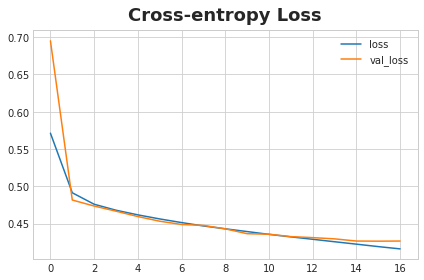

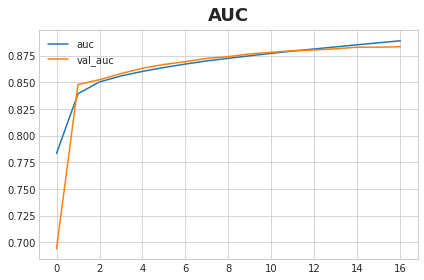

In [9]:
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot(title='Cross-entropy Loss')
history_frame.loc[:, ['auc', 'val_auc']].plot(title='AUC');